process for 2024 data:
1. first need to combine all images in the same folder, all rgb in one folder, all tiff in one folder and all MAT files from Segmented_by_sam in one folder

# **Mount & Import**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import glob
import shutil
import cv2
import numpy as np
import pandas as pd
import torch
from skimage.measure import regionprops, label
from skimage import color
from scipy.ndimage import binary_fill_holes
from scipy.spatial.distance import euclidean

In [1]:
import os
import glob
import shutil
import cv2
import numpy as np
import pandas as pd
import torch
from skimage.measure import regionprops, label
from skimage import color
from scipy.ndimage import binary_fill_holes
from scipy.spatial.distance import euclidean

# Specify the folder paths
folder_path = '/content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2024/All_RGB'
wrong_segmentation_folder = '/content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2024/All_RGB/wrong_segmentation'
anomaly_detected_scope_folder = '/content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2024/All_RGB/anomaly_detected_scope'
anomaly_original_folder = '/content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2024/All_RGB/anomaly_original_size'

# Ensure necessary folders exist
os.makedirs(wrong_segmentation_folder, exist_ok=True)
os.makedirs(anomaly_detected_scope_folder, exist_ok=True)
os.makedirs(anomaly_original_folder, exist_ok=True)

# Check and filter valid images based on center pixel
valid_images = []
image_files = glob.glob(os.path.join(folder_path, "*.JPG"))

for image_path in image_files:
    image = cv2.imread(image_path)
    print(f"image path:{image_path}")
    if image is None:
        print(f"Error loading image: {image_path}")
        continue
    height, width, _ = image.shape
    center_pixel = image[height // 2, width // 2]
    # Check if center pixel is NOT white
    if (center_pixel != [255, 255, 255]).any():
        valid_images.append(image_path)
    else:
        shutil.move(
            image_path,
            os.path.join(wrong_segmentation_folder, os.path.basename(image_path))
        )

if not valid_images:
    print("No valid images found. Exiting.")
    exit()

# CSV path
csv_path = os.path.join(anomaly_detected_scope_folder, "segment_details.csv")
columns = [
    "id", "segment_area", "mandarin_area", "relative_area",
    "segment_centroid_x", "segment_centroid_y",
    "mandarin_centroid_x", "mandarin_centroid_y",
    "centroid_distance", "area", "bbox_height", "bbox_width",
    "aspect_ratio", "extent", "solidity", "perimeter",
    "circularity", "equivalent_diameter", "mean_intensity",
    "max_intensity", "min_intensity"
]

# Write the header to the CSV initially
with open(csv_path, 'w') as f:
    pd.DataFrame(columns=columns).to_csv(f, index=False)

# Initialize a list to store all segment details for creating a DataFrame
segment_details = []

def save_segment(image_path, mask, segment_number, original_size, save_path, scope=True):
    """
    Save a segment with or without a scope. Checks if the file already
    exists; if yes, it skips saving but returns the name so CSV can still
    be updated.
    """
    resized_mask = cv2.resize(
        mask.astype(np.uint8),
        (original_size[1], original_size[0]),
        interpolation=cv2.INTER_NEAREST
    )
    original_image = cv2.imread(image_path)

    coords = np.argwhere(resized_mask > 0)
    if len(coords) == 0:
        print(f"No valid region found for {image_path} segment {segment_number}. Skipping...")
        return None

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    height, width = y_max - y_min, x_max - x_min
    scope_h, scope_w = int(height * 0.2), int(width * 0.2)
    y_min_scope = max(0, y_min - scope_h)
    x_min_scope = max(0, x_min - scope_w)
    y_max_scope = min(original_size[0], y_max + scope_h)
    x_max_scope = min(original_size[1], x_max + scope_w)

    segment_name = f"{os.path.splitext(os.path.basename(image_path))[0]}_{segment_number}.JPG"
    save_file_path = os.path.join(save_path, segment_name)

    # Check if this segment file already exists in the target folder
    if os.path.exists(save_file_path):
        print(f"File already exists, skipping save: {save_file_path}")
        return segment_name

    # If it doesn't exist, proceed with saving
    if scope:
        segment_with_scope = original_image[y_min_scope:y_max_scope, x_min_scope:x_max_scope]
        cv2.imwrite(save_file_path, segment_with_scope)
    else:
        cropped_segment = original_image[y_min_scope:y_max_scope, x_min_scope:x_max_scope]
        mask_cropped = resized_mask[y_min_scope:y_max_scope, x_min_scope:x_max_scope]
        white_background = np.ones_like(cropped_segment) * 255
        segment_with_white_bg = white_background.copy()
        segment_with_white_bg[mask_cropped > 0] = cropped_segment[mask_cropped > 0]
        cv2.imwrite(save_file_path, segment_with_white_bg)

    return segment_name

def calculate_region_properties(mask, original_image):
    """Calculate geometric and intensity properties of a segment."""
    original_height, original_width = original_image.shape[:2]
    resized_mask = cv2.resize(mask.astype(np.uint8),
                              (original_width, original_height),
                              interpolation=cv2.INTER_NEAREST)

    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
    filled_mask = binary_fill_holes(resized_mask).astype(int)
    labeled_mask = label(filled_mask)

    region = regionprops(labeled_mask, intensity_image=grayscale_image)[0]

    # Geometric properties
    area = region.area
    bbox = region.bbox  # (min_row, min_col, max_row, max_col)
    bbox_height = bbox[2] - bbox[0]
    bbox_width = bbox[3] - bbox[1]
    aspect_ratio = bbox_width / bbox_height if bbox_height > 0 else 0
    extent = region.extent
    solidity = region.solidity
    perimeter = region.perimeter
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
    equivalent_diameter = region.equivalent_diameter

    # Intensity properties
    mean_intensity = region.mean_intensity
    max_intensity = region.max_intensity
    min_intensity = region.min_intensity

    return {
        "area": area,
        "bbox_height": bbox_height,
        "bbox_width": bbox_width,
        "aspect_ratio": aspect_ratio,
        "extent": extent,
        "solidity": solidity,
        "perimeter": perimeter,
        "circularity": circularity,
        "equivalent_diameter": equivalent_diameter,
        "mean_intensity": mean_intensity,
        "max_intensity": max_intensity,
        "min_intensity": min_intensity,
    }

def calculate_relative_area(segment_mask, original_image):
    """Calculate relative area and centroids."""
    mandarin_mask = np.any(original_image != [255, 255, 255], axis=-1)
    mandarin_area = np.sum(mandarin_mask)

    resized_segment_mask = cv2.resize(
        segment_mask.astype(np.uint8),
        (original_image.shape[1], original_image.shape[0]),
        interpolation=cv2.INTER_NEAREST
    )
    segment_area = np.sum(resized_segment_mask)

    relative_area = segment_area / mandarin_area if mandarin_area > 0 else 0

    segment_centroid = np.mean(np.argwhere(resized_segment_mask > 0), axis=0)
    mandarin_centroid = np.mean(np.argwhere(mandarin_mask > 0), axis=0)

    segment_centroid_x, segment_centroid_y = segment_centroid[::-1]
    mandarin_centroid_x, mandarin_centroid_y = mandarin_centroid[::-1]

    centroid_distance = (
        euclidean(segment_centroid, mandarin_centroid)
        if segment_centroid.size > 0 and mandarin_centroid.size > 0
        else None
    )

    return {
        "segment_area": segment_area,
        "mandarin_area": mandarin_area,
        "relative_area": relative_area,
        "segment_centroid_x": segment_centroid_x,
        "segment_centroid_y": segment_centroid_y,
        "mandarin_centroid_x": mandarin_centroid_x,
        "mandarin_centroid_y": mandarin_centroid_y,
        "centroid_distance": centroid_distance,
    }

def process_segmented_image(image_path, current_idx, total_images):
    try:
        print(f"Processing image {current_idx}/{total_images}: {image_path}")

        image = cv2.imread(image_path)
        original_size = image.shape
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Downscale for mask generation
        scale_factor = 0.05
        new_width = int(original_size[1] * scale_factor)
        new_height = int(original_size[0] * scale_factor)
        resized_image = cv2.resize(image_rgb, (new_width, new_height))

        # Create mask for the entire mandarin
        mandarin_mask = np.any(resized_image != [255, 255, 255], axis=-1)
        mandarin_area = np.sum(mandarin_mask)

        # Generate masks using your mask_generator
        with torch.cuda.amp.autocast(dtype=torch.float16):
            masks = mask_generator.generate(resized_image)

        segment_number = 0
        for mask in masks:
            relative_area = mask['area'] / mandarin_area if mandarin_area > 0 else 0
            if relative_area < 0.8:
                segment_number += 1

                # Save the segment with scope
                save_segment(
                    image_path, mask['segmentation'],
                    segment_number, original_size,
                    anomaly_detected_scope_folder, scope=True
                )

                # Save the segment on a white background
                save_segment(
                    image_path, mask['segmentation'],
                    segment_number, original_size,
                    anomaly_original_folder, scope=False
                )

                # Calculate region & relative area properties
                region_props = calculate_region_properties(mask['segmentation'], image_rgb)
                relative_area_props = calculate_relative_area(mask['segmentation'], image)

                # Combine all properties into one dict
                segment_attributes = {
                    "id": f"{os.path.splitext(os.path.basename(image_path))[0]}_{segment_number}",
                    **relative_area_props,
                    **region_props,
                }

                # Append to CSV
                pd.DataFrame([segment_attributes]).to_csv(csv_path, mode='a', header=False, index=False)
                print(f"Added segment details to CSV: {segment_attributes['id']}")

                # Also keep it in memory for final DataFrame
                segment_details.append(segment_attributes)

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

total_images = len(valid_images)
for idx, image_path in enumerate(valid_images, start=1):
    process_segmented_image(image_path, idx, total_images)

# Write all segment details into a final CSV
final_csv_path = os.path.join(anomaly_detected_scope_folder, "final_segment_details.csv")
segments_df = pd.DataFrame(segment_details)
segments_df.to_csv(final_csv_path, index=False)
print(f"Full DataFrame saved to {final_csv_path}")


No valid images found. Exiting.
Full DataFrame saved to /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2024/All_RGB/anomaly_detected_scope/final_segment_details.csv


In [4]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: Mountpoint must not already contain files

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd

In [ ]:
import scipy.io


mat_file_path = r"/content/drive/Othercomputers/My PC/Thesis/raw_data/20231103/prediction/raw data/Thermal.MAT/new_name/10_n_1_20231103.MAT"  # or .mat — Windows doesn't mind the case
mat_contents = scipy.io.loadmat(mat_file_path)

# For debugging, see which variables are inside:
for key in mat_contents:
    if not key.startswith("__"):  # Skip internal Python keys
        value = mat_contents[key]
        if isinstance(value, np.ndarray):
            print(f"Variable '{key}': dtype={value.dtype}, shape={value.shape}")
        else:
            print(f"Variable '{key}': type={type(value)}")

# Check the dtype to determine bit depth
# e.g. if 'thermal_image' is your image array
thermal_image = mat_contents.get("thermal_image", None)
if thermal_image is not None:
    if thermal_image.dtype == np.uint8:
        print("The image is 8-bit (uint8).")
    elif thermal_image.dtype == np.uint16:
        print("The image is 16-bit (uint16).")
    else:
        print(f"The image is {thermal_image.dtype}, which is not 8 or 16-bit.")




Variable 'FLIR1729': dtype=float64, shape=(768, 1024)
Variable 'FLIR1729_DateTime': dtype=float64, shape=(1, 7)
Variable 'FLIR1729_ObjectParam': dtype=float64, shape=(1, 10)
Variable 'FLIR1729_Scaling': dtype=float64, shape=(1, 9)
Variable 'FLIR1729_FrameInfo': dtype=float64, shape=(1, 2)


# **Tabular Data creation**

get the csv

In [ ]:
# Path to the CSV file
csv_path = '/content/drive/Othercomputers/My PC/Thesis/combined_data_with_thermal_cleaned.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_path)

df.head()

,id,tree,direction,mandarin_number,date,tag,avg_red,avg_green,avg_blue,std_red,...,max_temp,median_temp,range_temp,skew_temp,kurtosis_temp,p25_temp,p75_temp,iqr_temp,entropy_temp,circularity
0,1_n_1_20230825,1,n,1,20230825,0,1.173631,3.267353,2.938598,8.405348,...,65168.0,0.0,65168.0,3.915920,16.062127,0.0,0.0,0.0,0.253043,0.611455
1,1_n_1_20230929,1,n,1,20230929,0,23.080680,23.095326,21.652693,48.962308,...,65400.0,0.0,65400.0,3.289335,8.819769,0.0,0.0,0.0,0.261655,0.674436
2,1_n_1_20231103,1,n,1,20231103,0,13.750980,13.507555,13.113424,40.518468,...,64961.0,0.0,64961.0,1.718984,0.954930,0.0,0.0,0.0,0.465770,0.667785
3,1_n_1_20231216,1,n,1,20231216,0,7.626912,12.835019,18.137301,20.289230,...,65281.8,0.0,65281.8,2.604132,5.808586,0.0,0.0,0.0,0.358867,0.669107
4,1_n_2_20230825,1,n,2,20230825,0,2.103231,2.680031,2.149817,15.455984,...,64779.8,0.0,64779.8,4.909860,23.052982,0.0,0.0,0.0,0.166969,0.636478


remove segments that aren't good - (pixel in the center is null )

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd  # assuming you are using pandas for the DataFrame

def process_images(df, image_directory, image_width, image_height, file_type="JPG"):
    """
    Process images by checking the center pixel and replacing all occurrences of (256,256,256)
    with (0,0,0) in each image. If the center pixel value is 0, sets specific DataFrame columns to None.

    Parameters:
      df (pandas.DataFrame): DataFrame containing at least an 'id' column (and optionally 'tag', 'height', 'width').
      image_directory (str): Path to the directory containing the images.
      image_width (int): Width of the images.
      image_height (int): Height of the images.
      file_type (str): File extension/type of the images (default is "JPG").

    Returns:
      pandas.DataFrame: A new DataFrame with rows removed that correspond to missing images or processing errors.
    """
    # Calculate the center coordinates of the image
    center_x, center_y = image_width // 2, image_height // 2
    images_to_remove = []  # list to keep track of rows to remove from the DataFrame

    for index, row in df.iterrows():
        image_id = row['id']
        image_path = os.path.join(image_directory, f"{image_id}.{file_type}")

        if os.path.exists(image_path):
            try:
                # Open the image
                image = Image.open(image_path)
                # Convert to RGB if needed
                if image.mode != 'RGB':
                    image = image.convert('RGB')

                # Convert image to a NumPy array for fast pixel replacement
                image_array = np.array(image)

                # Replace all pixels equal to (256, 256, 256) with (0, 0, 0)
                # (If your images are standard 8-bit, note that the max value is 255.)
                mask = np.all(image_array == [256, 256, 256], axis=-1)
                image_array[mask] = [0, 0, 0]

                # Create a new image from the modified array and save it back to disk.
                new_image = Image.fromarray(image_array)
                new_image.save(image_path)

                # Check the pixel at the center of the image (using the updated image)
                center_pixel = new_image.getpixel((center_x, center_y))
                # For grayscale images, the pixel may be an int; for RGB it is a tuple.
                if (isinstance(center_pixel, int) and center_pixel == 0) or \
                   (isinstance(center_pixel, tuple) and all(p == 0 for p in center_pixel)):
                    print(f"Image {image_id} has a center pixel value of 0.")
                    # Set all columns (except 'id', 'tag', 'height', 'width') to None.
                    df.loc[index, df.columns.difference(['id', 'tag', 'height', 'width'])] = None

            except Exception as e:
                print(f"Error processing image {image_id}: {e}")
                images_to_remove.append(index)
        else:
            print(f"Image not found: {image_id}")
            images_to_remove.append(index)

    # Remove rows that had errors or missing images
    df_cleaned = df.drop(index=images_to_remove)
    print(f"Number of images removed: {len(images_to_remove)}")

    return df_cleaned

# Example usage:
# Assuming 'df' is your DataFrame and your images are located in the given directory:
image_directory = '/content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/All_tiff/images'
image_width, image_height = 1024, 768
df_cleaned = process_images(df, image_directory, image_width, image_height, file_type="tiff")
print(df_cleaned.head())


Number of images removed: 0


,id,tree,direction,mandarin_number,date,avg_red,avg_green,avg_blue,std_red,std_green,std_blue,height,width,edge_density,tag
0,1_n_1_20230825,1,n,1,20230825,1.173631,3.267353,2.938598,8.405348,22.029888,19.857833,5464,8192,0.137934,0
1,1_n_1_20230929,1,n,1,20230929,23.080680,23.095326,21.652693,48.962308,48.486428,45.493625,5464,8192,0.191935,0
2,1_n_1_20231103,1,n,1,20231103,13.750980,13.507555,13.113424,40.518468,39.679547,38.675582,5464,8192,0.122740,0
3,1_n_1_20231216,1,n,1,20231216,7.626912,12.835019,18.137301,20.289230,29.559554,40.866454,5464,8192,0.232924,0
4,1_n_2_20230825,1,n,2,20230825,2.103231,2.680031,2.149817,15.455984,18.459059,15.112353,5464,8192,0.087966,0


get excel with id's and tags (and number of tree) and get features from rgb images and save in new csv file

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2

def process_csv_with_features(csv_path, rgb_folder):
    """
    Processes a CSV file by adding new columns and integrates features extracted from RGB images.

    Args:
    csv_path (str): Path to the CSV file.
    rgb_folder (str): Path to the folder containing RGB images.

    Returns:
    pd.DataFrame: Processed DataFrame.
    """
    # Required columns
    required_columns = {'id', 'tag', 'tree'}

    try:
        # Load the CSV file
        df = pd.read_csv(csv_path)

        # Check if all required columns exist
        missing_columns = required_columns - set(df.columns)
        if missing_columns:
            print(f"Missing columns: {', '.join(missing_columns)}")
            return None

        # Add 'direction' column (3rd letter from 'id')
        df['direction'] = df['id'].str[2]
     ################### NEED TO CHANGE #####################################################   df['direction'] = df['id'].str.split('_').str[1].str[0]

        # Add 'mandarin_number' column (number after the second '_')
        df['mandarin_number'] = df['id'].str.split('_').str[2]

        # Add a placeholder for date column
        df['date'] = pd.to_datetime(df['id'].str.split('_').str[-1], format='%Y%m%d')

        # Initialize list for RGB features
        features = []

        # Process all rows in the DataFrame
        for _, row in df.iterrows():
            image_id = row['id']
            image_file = f"{image_id}.JPG"
            image_path = os.path.join(rgb_folder, image_file)

            if os.path.exists(image_path):
                # Load the image
                image = cv2.imread(image_path)

                # Skip if the image could not be loaded
                if image is None:
                    print(f"Warning: Could not load {image_file}")
                    features.append([image_id, None, None, None, None, None, None, None])
                    continue

                # Check if the center pixel is non-black
                image_height, image_width, _ = image.shape
                center_pixel = image[image_height // 2, image_width // 2]
                if np.all(center_pixel == 0):  # Center pixel is black
                    print(f"Image {image_file} has a black center pixel. Skipping RGB features.")
                    features.append([image_id, None, None, None, None, None, None, None])
                    continue

                # Extract image features
                avg_color = np.mean(image, axis=(0, 1))
                std_color = np.std(image, axis=(0, 1))
                edge_density = np.sum(cv2.Canny(image, 100, 200)) / (image_height * image_width)

                # Add features to the list
                features.append([
                    image_id, avg_color[2], avg_color[1], avg_color[0],  # Red, Green, Blue
                    std_color[2], std_color[1], std_color[0], edge_density
                ])
            else:
                print(f"Image not found: {image_file}")
                features.append([image_id, None, None, None, None, None, None, None])

        # Create a DataFrame for image features
        features_df = pd.DataFrame(features, columns=[
            "id", "avg_red", "avg_green", "avg_blue",
            "std_red", "std_green", "std_blue", "edge_density"
        ])

        # Merge the features DataFrame with the main DataFrame
        combined_df = pd.merge(df, features_df, on='id', how='left')

        # Ensure the column order
        ordered_columns = [
            "id", "tree", "direction", "mandarin_number", "date",
            "avg_red", "avg_green", "avg_blue",
            "std_red", "std_green", "std_blue", "edge_density", "tag"
        ]
        combined_df = combined_df[ordered_columns]

        # Return the combined DataFrame
        return combined_df

    except FileNotFoundError:
        print(f"File not found: {csv_path} or {rgb_folder}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage
csv_path = '/content/drive/Othercomputers/My PC/Thesis/2023_Tags_.csv'
rgb_folder = '/content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/All_RGB'
combined_df = process_csv_with_features(csv_path, rgb_folder)

# Save the resulting DataFrame to a new CSV
if combined_df is not None:
    combined_df.to_csv('/content/drive/Othercomputers/My PC/Thesis/2023_RGB_Features_Processed.csv', index=False)
    print("Processing complete. Combined DataFrame saved.")


Image 1_n_1_20230825.JPG has a black center pixel. Skipping RGB features.
Image 1_s_6_20230825.JPG has a black center pixel. Skipping RGB features.
Image 1_s_6_20230929.JPG has a black center pixel. Skipping RGB features.
Image 2_n_10_20231103.JPG has a black center pixel. Skipping RGB features.
Image 2_n_2_20230825.JPG has a black center pixel. Skipping RGB features.
Image 2_n_7_20230825.JPG has a black center pixel. Skipping RGB features.
Image 2_s_3_20230825.JPG has a black center pixel. Skipping RGB features.
Image 2_s_3_20231103.JPG has a black center pixel. Skipping RGB features.
Image 3_n_9,10_20230825.JPG has a black center pixel. Skipping RGB features.
Image 3_n_9,10_20231216.JPG has a black center pixel. Skipping RGB features.
Image 3_s_2_20230929.JPG has a black center pixel. Skipping RGB features.
Image 4_n_5_20231103.JPG has a black center pixel. Skipping RGB features.
Image 4_n_5_20231216.JPG has a black center pixel. Skipping RGB features.
Image 4_s_3_20230825.JPG has a 

add thermal data from MAT files

In [ ]:
import os
import numpy as np
import scipy.io as sio
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
from skimage import measure, morphology

# Define paths
csv_path = '/content/drive/Othercomputers/My PC/Thesis/combined_data_2023_updated.csv'
mat_folder = '/content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/All_MAT'

# Load CSV into a DataFrame
df = pd.read_csv(csv_path)

# Circularity threshold (adjust based on analysis)
CIRCULARITY_THRESHOLD = 0.5

# Function to calculate circularity
def calculate_circularity(binary_mask):
    """Calculates circularity using region properties."""
    try:
        # Ensure binary mask is properly formatted
        binary_mask = binary_mask.astype(np.uint8)  # Convert to uint8 (0s and 1s)

        # Label connected regions
        labeled_mask = measure.label(binary_mask)
        regions = measure.regionprops(labeled_mask)

        if not regions:
            return np.nan  # No valid object found

        # Get largest connected component (assumes it's the mandarin)
        largest_region = max(regions, key=lambda r: r.area)

        # Compute circularity
        perimeter = largest_region.perimeter
        area = largest_region.area

        if perimeter == 0:
            return np.nan  # Avoid division by zero

        circularity = (4 * np.pi * area) / (perimeter ** 2)
        return circularity

    except Exception as e:
        print(f"⚠️ Circularity calculation error: {e}")
        return np.nan  # Assign NaN if error occurs

# Function to extract thermal features from a MAT file
def extract_thermal_features(mat_path, img_id):
    """Loads a MAT file and extracts statistical features from the thermal matrix."""
    try:
        mat_data = sio.loadmat(mat_path)  # Load .MAT file
        key = [k for k in mat_data.keys() if not k.startswith("__")][0]  # Get thermal data key
        thermal_array = mat_data[key]  # Extract thermal matrix

        # Ensure it's a NumPy array
        if isinstance(thermal_array, list):
            thermal_array = np.array(thermal_array)

        # Check if the center pixel is zero (background case)
        center_x, center_y = thermal_array.shape[0] // 2, thermal_array.shape[1] // 2
        if thermal_array[center_x, center_y] == 0:
            print(f"⚠️ Skipping {img_id}: Center pixel is zero (background detected).")
            return {key: np.nan for key in [
                "avg_temp", "std_temp", "min_temp", "max_temp", "median_temp",
                "range_temp", "skew_temp", "kurtosis_temp", "p25_temp", "p75_temp",
                "iqr_temp", "entropy_temp", "circularity"
            ]}

        # Compute circularity
        binary_mask = thermal_array > 0  # Create binary mask (nonzero = object)
        circularity = calculate_circularity(binary_mask)

        # Check if the shape is circular enough
        if circularity < CIRCULARITY_THRESHOLD:
            print(f"⚠️ Skipping {img_id}: Circularity {circularity:.2f} is below threshold.")
            return {key: np.nan for key in [
                "avg_temp", "std_temp", "min_temp", "max_temp", "median_temp",
                "range_temp", "skew_temp", "kurtosis_temp", "p25_temp", "p75_temp",
                "iqr_temp", "entropy_temp", "circularity"
            ]}

        # Flatten to 1D array
        thermal_values = thermal_array.flatten()

        # Compute features
        features = {
            "avg_temp": np.mean(thermal_values),
            "std_temp": np.std(thermal_values),
            "min_temp": np.min(thermal_values),
            "max_temp": np.max(thermal_values),
            "median_temp": np.median(thermal_values),
            "range_temp": np.max(thermal_values) - np.min(thermal_values),
            "skew_temp": skew(thermal_values),
            "kurtosis_temp": kurtosis(thermal_values),
            "p25_temp": np.percentile(thermal_values, 25),
            "p75_temp": np.percentile(thermal_values, 75),
            "iqr_temp": np.percentile(thermal_values, 75) - np.percentile(thermal_values, 25),
            "entropy_temp": entropy(np.histogram(thermal_values, bins=50)[0]),
            "circularity": circularity
        }
        return features

    except Exception as e:
        print(f"⚠️ Error processing {img_id}: {e}")
        return {key: np.nan for key in [
            "avg_temp", "std_temp", "min_temp", "max_temp", "median_temp",
            "range_temp", "skew_temp", "kurtosis_temp", "p25_temp", "p75_temp",
            "iqr_temp", "entropy_temp", "circularity"
        ]}  # Assign NaN if file is missing or corrupted

# Extract thermal data and merge with the dataframe
thermal_data = []
for index, row in df.iterrows():
    img_id = row["id"]  # Get image ID
    mat_filename = f"{img_id}_masked.MAT"  # Construct corresponding MAT filename
    mat_path = os.path.join(mat_folder, mat_filename)

    # Print progress every 50 rows
    if index % 50 == 0:
        print(f"Processing row {index}/{len(df)}: {img_id}")

    # Check if the MAT file exists
    if os.path.exists(mat_path):
        features = extract_thermal_features(mat_path, img_id)
    else:
        print(f"⚠️ Missing MAT file for {img_id}")
        features = {key: np.nan for key in [
            "avg_temp", "std_temp", "min_temp", "max_temp", "median_temp",
            "range_temp", "skew_temp", "kurtosis_temp", "p25_temp", "p75_temp",
            "iqr_temp", "entropy_temp", "circularity"
        ]}  # Assign NaN if file is missing

    thermal_data.append(features)

# Convert thermal data to a DataFrame
thermal_df = pd.DataFrame(thermal_data)

# Concatenate with the original dataframe while keeping "tag" as the last column
tag_col = df.pop("tag")  # Remove 'tag' column temporarily
df = pd.concat([df, thermal_df], axis=1)  # Merge new features
df["tag"] = tag_col  # Add 'tag' back to the end

# Save the updated DataFrame
updated_csv_path = "/content/drive/Othercomputers/My PC/Thesis/combined_data_with_thermal.csv"
df.to_csv(updated_csv_path, index=False)

print(f"✅ Updated DataFrame saved to: {updated_csv_path}")


Processing row 0/1169: 1_n_1_20230825
⚠️ Missing MAT file for 1_n_1_20230825
⚠️ Skipping 1_n_1_20231216: Center pixel is zero (background detected).
⚠️ Missing MAT file for 1_n_2_20230825
⚠️ Missing MAT file for 1_n_3_20230825
⚠️ Skipping 1_n_4_20230825: Center pixel is zero (background detected).
⚠️ Skipping 1_s_6_20230825: Center pixel is zero (background detected).
⚠️ Skipping 2_n_10_20231103: Center pixel is zero (background detected).
Processing row 50/1169: 2_n_11_20230929
⚠️ Skipping 2_n_12_20231103: Circularity 0.37 is below threshold.
⚠️ Skipping 2_n_12_20231216: Center pixel is zero (background detected).
⚠️ Skipping 2_n_13_20230825: Center pixel is zero (background detected).
⚠️ Skipping 2_n_15_20231216: Center pixel is zero (background detected).
⚠️ Skipping 2_n_2_20231103: Center pixel is zero (background detected).
⚠️ Skipping 2_n_7_20230825: Center pixel is zero (background detected).
⚠️ Skipping 2_n_7_20231216: Circularity 0.48 is below threshold.
⚠️ Skipping 2_n_9_2023

deal with missing values for thermal features

In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer

# Load the CSV file
csv_path = "/content/drive/Othercomputers/My PC/Thesis/combined_data_with_thermal.csv"
df = pd.read_csv(csv_path)

# Identify non-numeric columns (to be excluded from KNN imputation)
non_numeric_cols = ["id", "tree", "direction", "mandarin_number", "date", "tag"]

# Ensure only existing columns are selected
existing_non_numeric_cols = [col for col in non_numeric_cols if col in df.columns]

# Separate numeric and non-numeric data
numeric_df = df.drop(columns=existing_non_numeric_cols)  # Keep only numeric columns

# Apply KNN imputation on numeric data
imputer = KNNImputer(n_neighbors=5)
numeric_imputed = pd.DataFrame(imputer.fit_transform(numeric_df), columns=numeric_df.columns)

# Merge back with the non-numeric columns
df_imputed = pd.concat([df[existing_non_numeric_cols], numeric_imputed], axis=1)

# Save the cleaned dataset
cleaned_csv_path = "/content/drive/Othercomputers/My PC/Thesis/combined_data_with_thermal_cleaned.csv"
df_imputed.to_csv(cleaned_csv_path, index=False)

print(f"✅ Cleaned dataset saved to: {cleaned_csv_path}")

# Display first few rows to verify results
df_imputed.head()


✅ Cleaned dataset saved to: /content/drive/Othercomputers/My PC/Thesis/combined_data_with_thermal_cleaned.csv


,id,tree,direction,mandarin_number,date,tag,avg_red,avg_green,avg_blue,std_red,...,max_temp,median_temp,range_temp,skew_temp,kurtosis_temp,p25_temp,p75_temp,iqr_temp,entropy_temp,circularity
0,1_n_1_20230825,1,n,1,20230825,0,1.173631,3.267353,2.938598,8.405348,...,65168.0,0.0,65168.0,3.915920,16.062127,0.0,0.0,0.0,0.253043,0.611455
1,1_n_1_20230929,1,n,1,20230929,0,23.080680,23.095326,21.652693,48.962308,...,65400.0,0.0,65400.0,3.289335,8.819769,0.0,0.0,0.0,0.261655,0.674436
2,1_n_1_20231103,1,n,1,20231103,0,13.750980,13.507555,13.113424,40.518468,...,64961.0,0.0,64961.0,1.718984,0.954930,0.0,0.0,0.0,0.465770,0.667785
3,1_n_1_20231216,1,n,1,20231216,0,7.626912,12.835019,18.137301,20.289230,...,65281.8,0.0,65281.8,2.604132,5.808586,0.0,0.0,0.0,0.358867,0.669107
4,1_n_2_20230825,1,n,2,20230825,0,2.103231,2.680031,2.149817,15.455984,...,64779.8,0.0,64779.8,4.909860,23.052982,0.0,0.0,0.0,0.166969,0.636478


# **Feature selection**

In [9]:
# Path to the CSV file
csv_path = '/content/drive/Othercomputers/My PC/Thesis/combined_data_with_thermal_cleaned.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_path)

df.head()

,id,tree,direction,mandarin_number,date,tag,avg_red,avg_green,avg_blue,std_red,...,max_temp,median_temp,range_temp,skew_temp,kurtosis_temp,p25_temp,p75_temp,iqr_temp,entropy_temp,circularity
0,1_n_1_20230825,1,n,1,20230825,0,1.173631,3.267353,2.938598,8.405348,...,65168.0,0.0,65168.0,3.915920,16.062127,0.0,0.0,0.0,0.253043,0.611455
1,1_n_1_20230929,1,n,1,20230929,0,23.080680,23.095326,21.652693,48.962308,...,65400.0,0.0,65400.0,3.289335,8.819769,0.0,0.0,0.0,0.261655,0.674436
2,1_n_1_20231103,1,n,1,20231103,0,13.750980,13.507555,13.113424,40.518468,...,64961.0,0.0,64961.0,1.718984,0.954930,0.0,0.0,0.0,0.465770,0.667785
3,1_n_1_20231216,1,n,1,20231216,0,7.626912,12.835019,18.137301,20.289230,...,65281.8,0.0,65281.8,2.604132,5.808586,0.0,0.0,0.0,0.358867,0.669107
4,1_n_2_20230825,1,n,2,20230825,0,2.103231,2.680031,2.149817,15.455984,...,64779.8,0.0,64779.8,4.909860,23.052982,0.0,0.0,0.0,0.166969,0.636478


In [5]:
pip install matplotlib seaborn


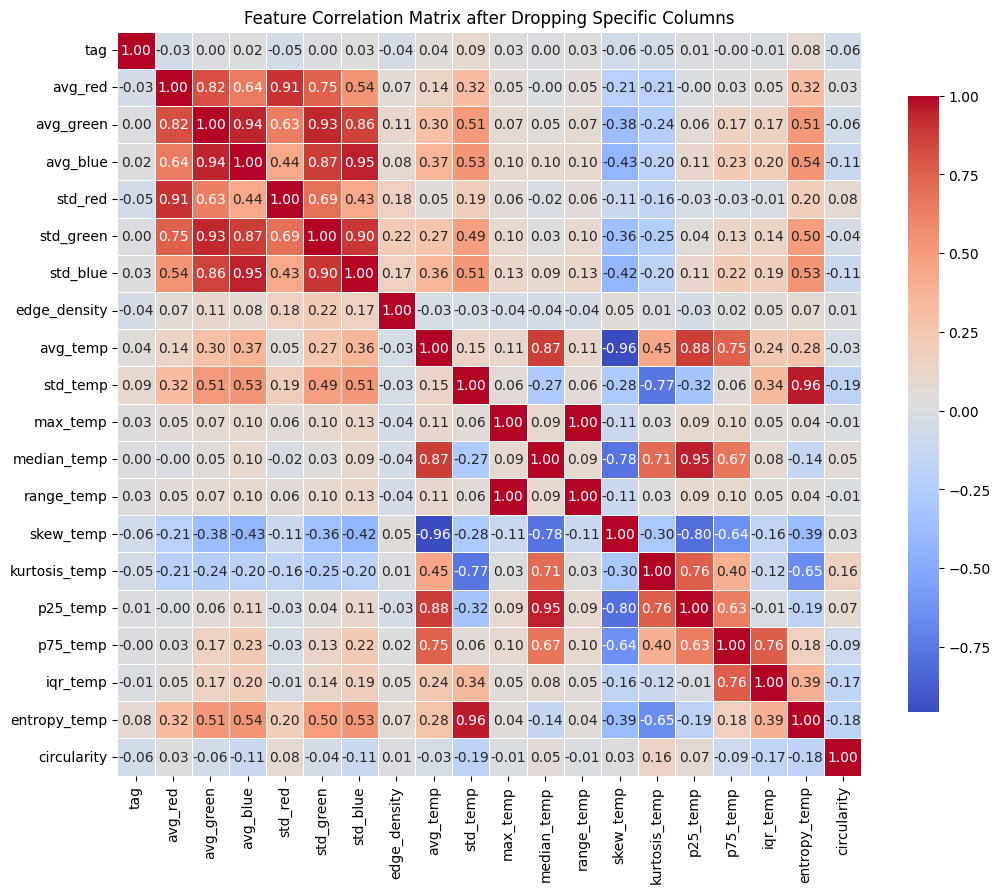

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the specified non-feature columns along with 'id' and 'tag'
columns_to_drop = ['id', 'tree', 'direction', 'mandarin_number', 'date', 'height','width','min_temp']
df_cleaned = df.drop(columns_to_drop, axis=1)

# Calculate the correlation matrix of the cleaned DataFrame
corr = df_cleaned.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .8})

# Show plot
plt.title('Feature Correlation Matrix after Dropping Specific Columns')
plt.show()

In [8]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Define features and target
X = df_cleaned.drop('tag', axis=1)  # drop the target to isolate features
y = df_cleaned['tag']  # define the target

# ✅ Split the data BEFORE feature selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the base classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# ✅ Perform feature selection ONLY on training data
selector = RFE(estimator=model, n_features_to_select=10, step=1)
selector.fit(X_train, y_train)

# ✅ Get the selected features from training data
selected_features = X_train.columns[selector.support_]

print("Selected Features:", list(selected_features))


Selected Features: ['avg_red', 'avg_green', 'std_blue', 'edge_density', 'avg_temp', 'range_temp', 'skew_temp', 'kurtosis_temp', 'entropy_temp', 'circularity']


In [10]:
# ✅ No need to check feature ranks, just use the selected features
top_features = list(selected_features)

# Print selected top features
print("Top features (Rank 1 or 2):", top_features)


Top features (Rank 1 or 2): ['avg_red', 'avg_green', 'std_blue', 'edge_density', 'avg_temp', 'range_temp', 'skew_temp', 'kurtosis_temp', 'entropy_temp', 'circularity']


In [11]:
# ✅ Apply selected features to both train and test sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# ✅ Keep 'tag' in a separate variable
df_selected_train = pd.concat([X_train_selected, y_train], axis=1)
df_selected_test = pd.concat([X_test_selected, y_test], axis=1)

# Display the first few rows to confirm
print(df_selected_train.head())


       avg_red  avg_green   std_blue  edge_density      avg_temp  range_temp  \
593  16.894659  21.001307  45.033623      1.117130   4461.849136     65503.0   
788  15.919852  18.561607  36.847696      0.206559   4873.935515     65088.0   
490   8.050046   8.981309  21.863756      0.490282   2622.065562     64885.0   
654  26.632763  28.577026  54.195767      0.406139  10723.571277     65248.8   
963   6.512043   9.128072  30.032842      0.401672   5670.901987     65199.0   

     skew_temp  kurtosis_temp  entropy_temp  circularity  tag  
593   3.425250       9.732341      0.249002     0.664960    0  
788   3.227364       8.415891      0.266364     0.653242    0  
490   4.653528      19.655348      0.169938     0.662320    0  
654   1.851055       1.538501      0.442678     0.669375    0  
963   3.061414       7.756380      0.291351     0.652385    0  


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# ✅ Standardize features based on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)  # Fit only on training data
X_test_scaled = scaler.transform(X_test_selected)  # Apply to test data

# Initialize the RandomForest classifier
model = RandomForestClassifier(random_state=42)

# Cross-validation to tune parameters and avoid overfitting
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# ✅ Use X_train_scaled and y_train (not df_selected!)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Predict on the test data
y_pred = best_model.predict(X_test_scaled)

# Calculate and print the accuracy of the model
accuracy = best_model.score(X_test_scaled, y_test)
print(f"Accuracy of the model on the test data: {accuracy:.2f}")

# Print classification report and confusion matrix for detailed analysis
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: Display feature importances
feature_importances = pd.DataFrame(best_model.feature_importances_,
                                   index=selected_features,
                                   columns=['importance']).sort_values('importance', ascending=False)
print("Feature Importances:\n", feature_importances)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Accuracy of the model on the test data: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       334
           1       0.00      0.00      0.00        17

    accuracy                           0.95       351
   macro avg       0.48      0.50      0.49       351
weighted avg       0.91      0.95      0.93       351

Confusion Matrix:
 [[334   0]
 [ 17   0]]
Feature Importances:
                importance
std_blue         0.121770
edge_density     0.118026
circularity      0.109274
kurtosis_temp    0.103158
skew_temp        0.097167
avg_green        0.096785
avg_temp         0.095978
entropy_temp     0.094017
range_temp       0.088647
avg_red          0.075179


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# ✅ Re-run training using correctly scaled features
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       334
           1       0.00      0.00      0.00        17

    accuracy                           0.95       351
   macro avg       0.48      0.50      0.49       351
weighted avg       0.91      0.95      0.93       351



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Count the number of instances for each class in the 'tag' column
class_distribution = y.value_counts()

# Print the distribution
print("Class Distribution in 'tag':")
print(class_distribution)

Class Distribution in 'tag':
tag
0    1124
1      45
Name: count, dtype: int64


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# ✅ Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# ✅ Train on SMOTE-balanced data
model.fit(X_train_smote, y_train_smote)

# Predict on the test data (use X_test_scaled)
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model on the test data: {accuracy:.2f}")

# Display classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Display feature importances
feature_importances = pd.DataFrame(best_model.feature_importances_,
                                   index=selected_features,
                                   columns=['importance']).sort_values('importance', ascending=False)
print("Feature Importances:\n", feature_importances)


Accuracy of the model on the test data: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       334
           1       0.00      0.00      0.00        17

    accuracy                           0.91       351
   macro avg       0.47      0.48      0.48       351
weighted avg       0.90      0.91      0.91       351

Confusion Matrix:
 [[319  15]
 [ 17   0]]
Feature Importances:
                importance
std_blue         0.121770
edge_density     0.118026
circularity      0.109274
kurtosis_temp    0.103158
skew_temp        0.097167
avg_green        0.096785
avg_temp         0.095978
entropy_temp     0.094017
range_temp       0.088647
avg_red          0.075179


smote - again

In [16]:
from imblearn.combine import SMOTETomek

smote = SMOTETomek(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


In [17]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced_subsample")


In [18]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# Apply scaling AFTER SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test_selected)


In [19]:
from imblearn.combine import SMOTETomek  # Use SMOTETomek instead of basic SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ✅ Apply SMOTETomek on training data (BEFORE SCALING)
smote = SMOTETomek(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# ✅ Standardize AFTER SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test_selected)

# ✅ Train model with class balancing
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced_subsample")
model.fit(X_train_scaled, y_train_smote)

# ✅ Predict on test data
y_pred = model.predict(X_test_scaled)

# ✅ Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model on the test data: {accuracy:.2f}")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy of the model on the test data: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       334
           1       0.00      0.00      0.00        17

    accuracy                           0.91       351
   macro avg       0.47      0.48      0.48       351
weighted avg       0.90      0.91      0.91       351

Confusion Matrix:
 [[321  13]
 [ 17   0]]
